In [8]:
import sys

sys.path.append('../..')
import torchdyn; from torchdyn.models import *; from torchdyn.datasets import *
from pytorch_lightning.loggers import WandbLogger

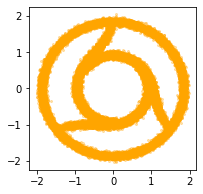

In [9]:
data = ToyDataset()
n_samples = 1 << 16
n_gaussians = 7

X, yn = data.generate(n_samples, 'diffeq_logo', noise=0.05)
X = (X - X.mean())/X.std()

import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.scatter(X[:,0], X[:,1], c='orange', alpha=0.3, s=4)

In [11]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = torch.Tensor(X).to(device)
train = data.TensorDataset(X_train)
trainloader = data.DataLoader(train, batch_size=512, shuffle=True) 

## Model

In [41]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical
prior = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

f = nn.Sequential(
        nn.Linear(2, 32),
        nn.Softplus(),
        nn.Linear(32, 32),
        nn.Softplus(),
        nn.Linear(32, 2)
    )

# cnf wraps the net as with other energy models
noise_dist = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

cnf = nn.Sequential(CNF(f, trace_estimator=hutch_trace, noise_dist=noise_dist))

nde = NeuralDE(cnf, solver='dopri5', s_span=torch.linspace(0, 1, 2), atol=1e-5, rtol=1e-5, sensitivity='adjoint')

model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),
                      nde).to(device)

## Learner

In [42]:
def cnf_density(model):
    cnf[0].trace_estimator = autograd_trace
    with torch.no_grad():
        npts = 200
        side = np.linspace(-2., 2., npts)
        xx, yy = np.meshgrid(side, side)
        memory= 100

        x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
        x = torch.from_numpy(x).type(torch.float32).to(device)

        z, delta_logp = [], []
        inds = torch.arange(0, x.shape[0]).to(torch.int64)
        for ii in torch.split(inds, int(memory**2)):
            z_full = model(x[ii]).cpu().detach()
            z_, delta_logp_ = z_full[:, 1:], z_full[:, 0]
            z.append(z_)
            delta_logp.append(delta_logp_)

        z = torch.cat(z, 0)
        delta_logp = torch.cat(delta_logp, 0)

        logpz = prior.log_prob(z.cuda()).cpu() # logp(z)
        logpx = logpz - delta_logp
        px = np.exp(logpx.cpu().numpy()).reshape(npts, npts)
        plt.imshow(px);
        plt.xlabel([])
        plt.ylabel([])
        cnf[0].trace_estimator = hutch_trace


In [43]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.lr = 1e-3
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        # plot logging  
        if batch_idx == 0: 
            cnf_density(self.model)
            self.logger.experiment.log({"chart": plt})
            plt.close()
            nde.nfe = 0
        
        x = batch[0]     
        x += 1e-3*torch.randn_like(x).to(x)
        xtrJ = self.model(x)  
        logprob = prior.log_prob(xtrJ[:,1:]).to(x) - xtrJ[:,0] 
        loss = -torch.mean(logprob)
        
        nfe = nde.nfe
        nde.nfe = 0
        
        metrics = {'loss': loss, 'nfe':nfe}
        self.logger.experiment.log(metrics) 
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-5)

    def train_dataloader(self):
        self.loader_l = len(trainloader)
        return trainloader

In [44]:
logger = WandbLogger(project='torchdyn-toy_ffjord-bench')
learn = Learner(model)
trainer = pl.Trainer(min_steps=10000, max_steps=10000, gpus=1, logger=logger)
trainer.fit(learn);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1 K   
/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [39]:
sample = prior.sample(torch.Size([1<<16]))
# integrating from 1 to 0, 8 steps of rk4
model[1].s_span = torch.linspace(1, 0, 2)
new_x = model(sample).cpu().detach()

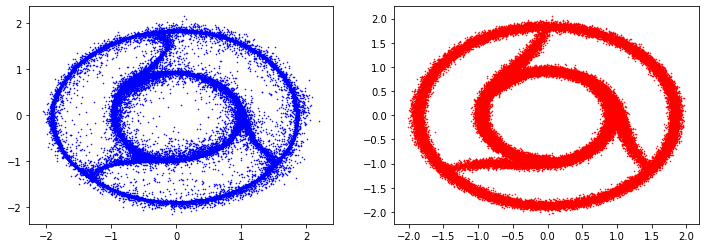

In [40]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,1], new_x[:,2], s=0.3, c='blue')
#plt.scatter(boh[:,0], boh[:,1], s=0.3, c='black')

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=0.3, c='red')

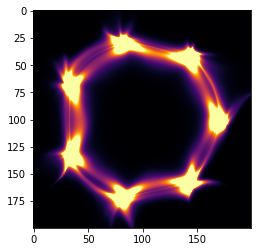

In [69]:
def cnf_density(model):
    with torch.no_grad():
        npts = 200
        side = np.linspace(-2., 2., npts)
        xx, yy = np.meshgrid(side, side)
        memory= 100

        x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
        x = torch.from_numpy(x).type(torch.float32).to(device)

        z, delta_logp = [], []
        inds = torch.arange(0, x.shape[0]).to(torch.int64)
        for ii in torch.split(inds, int(memory**2)):
            z_full = model(x[ii]).cpu().detach()
            z_, delta_logp_ = z_full[:, 1:], z_full[:, 0]
            z.append(z_)
            delta_logp.append(delta_logp_)

        z = torch.cat(z, 0)
        delta_logp = torch.cat(delta_logp, 0)

        logpz = prior.log_prob(z.cuda()).cpu() # logp(z)
        logpx = logpz - delta_logp
        px = np.exp(logpx.cpu().numpy()).reshape(npts, npts)
        plt.imshow(px, cmap='inferno', vmax=px.mean());
a = cnf_density(model)       